# Inverse Probability Weights

### Demonstration of the IPTW class, using an example from Cole and Hernan. "Adjusted survival curves with inverse probability weights" DOI: 10.1016/j.cmpb.2003.10.004

Using this code:
   Run code through the terminal. The Ewing Sarcoma data will be loaded from zEpid and the process of estimating IPW
   will be completed

Graph of survival curves (weighted and unweighted) are created

#### Versions:
    zEpid 0.3.0
    Python 3.6.3
    numpy v1.14.5
    pandas v0.23.0
    lifelines v0.14.6

 Code by: Paul Zivich,                                                      Last edit: 2018/08/28
 
 *NOTE:* as of v0.8.0, this approach is no longer possible. You will need to use 0.7.2 release. A future update will include a separate class (`SurvivalIPTW`) to conduct this analysis

## Step 0) Setting up environment

In [7]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import zepid as ze
from zepid.causal.ipw import IPTW

%matplotlib inline

df = ze.load_ewing_sarcoma_data()
df['id'] = [i for i in range(df.shape[0])]

## Step 1) Estimating Inverse Probability Weights

In [4]:
ipt = IPTW(df,  # pandas dataframe object
           treatment='treat',  # treatment/exposure column label
           stabilized=True)  # optional argument with True as default
ipt.regression_models('ldh')  # regression model (only a single variable in this example)
ipt.fit()  # generating IPTW (will be contained in IPTW.Weight)


----------------------------------------------------------------
MODEL: treat ~ ldh
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  treat   No. Observations:                   76
Model:                            GLM   Df Residuals:                       74
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -44.527
Date:                Tue, 28 Aug 2018   Deviance:                       89.054
Time:                        08:06:14   Pearson chi2:                     76.0
No. Iterations:                     4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

## Step 2) Extracting Weights from fitted IPTW class object 

In [8]:
df['iptw'] = ipt.Weight  # extracting weights and adding to a new column in our dataframe
print(round(df['iptw'].sum(), 5))  # Checking that stabilized weights add to original sample size

df_t = df.loc[df['treat'] == 1].copy()  # Dividing data into novel treatment vs standard treatment
df_u = df.loc[df['treat'] == 0].copy()

76.0


## Step 3a) Fitting unweighted (naive) Kaplan Meier

In [13]:
kmn_t = KaplanMeierFitter()  # Among Novel treatment
kmn_t.fit(durations=df_t['time'], event_observed=df_t['outcome'])
unad_t = kmn_t.event_table
unad_t['survival'] = kmn_t.survival_function_
plot_u_t = unad_t.loc[unad_t['observed'] == 1].copy()

kmn_u = KaplanMeierFitter()  # Among Standard treatment
kmn_u.fit(durations=df_u['time'], event_observed=df_u['outcome'])
unad_u = kmn_u.event_table
unad_u['survival'] = kmn_u.survival_function_
plot_u_u = unad_u.loc[unad_u.index < 1500].copy()

## Step 3b) Fitting weighted (IPW) Kaplan Meier

In [14]:
kmn_t = KaplanMeierFitter()  # Among Novel treatment
kmn_t.fit(durations=df_t['time'], event_observed=df_t['outcome'], weights=df_t['iptw'])
ad_t = kmn_t.event_table
ad_t['survival'] = kmn_t.survival_function_
plot_a_t = ad_t.loc[ad_t['observed'] != 0].copy()

kmn_u = KaplanMeierFitter()  # Among Standard treatment
kmn_u.fit(durations=df_u['time'], event_observed=df_u['outcome'], weights=df_u['iptw'])
ad_u = kmn_u.event_table
ad_u['survival'] = kmn_u.survival_function_
plot_a_u = ad_u.loc[ad_u.index < 1500].copy()

C:\Users\zivic\AppData\Local\Programs\Python\Python35-32\lib\site-packages\lifelines\utils\__init__.py:250: RuntimeWarning: It looks like your weights are not integers, possibly prospenity scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                
  """, RuntimeWarning)


## Step 4) Generating Figure 1

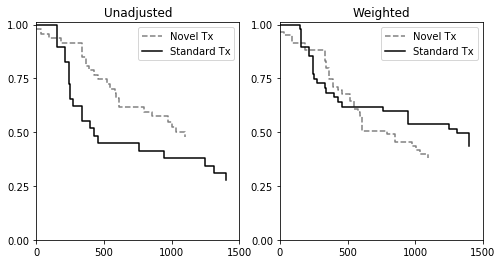

In [15]:
plt.figure(figsize=[8, 4])
gspec = gridspec.GridSpec(1, 2)
una = plt.subplot(gspec[0, 0:1])
adj = plt.subplot(gspec[0, 1:])

una.step(plot_u_t.index, plot_u_t.survival, linestyle='--', c='gray', where='post', label='Novel Tx')
una.step(plot_u_u.index, plot_u_u.survival, c='k', where='post', label='Standard Tx')
una.set_ylim([0, 1.01])
una.set_xlim([0, 1500])
una.set_yticks([0.0, 0.25, 0.50, 0.75, 1.00])
una.set_xticks([0, 500, 1000, 1500])
una.legend()
una.set_title('Unadjusted')
adj.step(plot_a_t.index, plot_a_t.survival, linestyle='--', c='gray', where='post', label='Novel Tx')
adj.step(plot_a_u.index, plot_a_u.survival, c='k', where='post', label='Standard Tx')
adj.set_ylim([0, 1.01])
adj.set_xlim([0, 1500])
adj.set_yticks([0.0, 0.25, 0.50, 0.75, 1.00])
adj.set_xticks([0, 500, 1000, 1500])
adj.legend()
adj.set_title('Weighted')
plt.show()